# Plotting Covid-19 data from Belgium

Source of data: [RTBF](https://www.rtbf.be/info/societe/detail_coronavirus-en-belgique-les-chiffres-du-nombre-de-personnes-hospitalisees-infographie?id=10458755). Last update 31/03.

Source for 01/04: [RTBF](https://www.rtbf.be/info/belgique/detail_coronavirus-en-belgique-suivez-en-direct-le-bilan-quotidien-du-centre-de-crise?id=10472832)

Source for 07/04: [Le Soir](https://www.lesoir.be/292851/article/2020-04-07/coronavirus-2035-deces-au-total-en-belgique-314-nouvelles-hospitalisations)

This is not (data) science, it's just a plot of some data and a linear regression.

License [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
%pylab inline
import requests
import pandas as pd
from datetime import date, timedelta

import matplotlib
matplotlib.rc('figure', figsize=(15, 8))

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_all(columns=['TOTAL_IN', 'TOTAL_IN_ICU', 'TOTAL_IN_RESP', 'TOTAL_IN_ECMO'], figsize=(24, 12)):
    def wrapper(func):
        n_plots = len(columns)
        n_cols = int(ceil(np.sqrt(n_plots)))
        n_rows = int(ceil(n_plots / n_cols))
        fig = plt.figure(figsize=figsize)
        for i, col in enumerate(columns):
            row = 1 + i // n_cols
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            func(ax, col)
            ax.set_title(col)
            if row < n_rows:
                ax.set_xticklabels([])
        fig.suptitle(' '.join(func.__name__.split('_')))
    return wrapper

In [3]:
sciensano_data = requests.get('https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv')
with open('hospital-data-be.csv', 'wb') as out:
    out.write(sciensano_data.content)
df = pd.read_csv('hospital-data-be.csv')
df = df.groupby([pd.to_datetime(df.DATE), df.PROVINCE]).sum().unstack()

In [4]:
PEAK_FIRST_WAVE = df[:'2020-07-21'].max()
PEAK_FIRST_WAVE

              PROVINCE      
NR_REPORTING  Antwerpen         17
              BrabantWallon      3
              Brussels          16
              Hainaut           15
              Limburg            7
                                ..
NEW_OUT       Luxembourg        17
              Namur             23
              OostVlaanderen    75
              VlaamsBrabant     34
              WestVlaanderen    57
Length: 77, dtype: int64

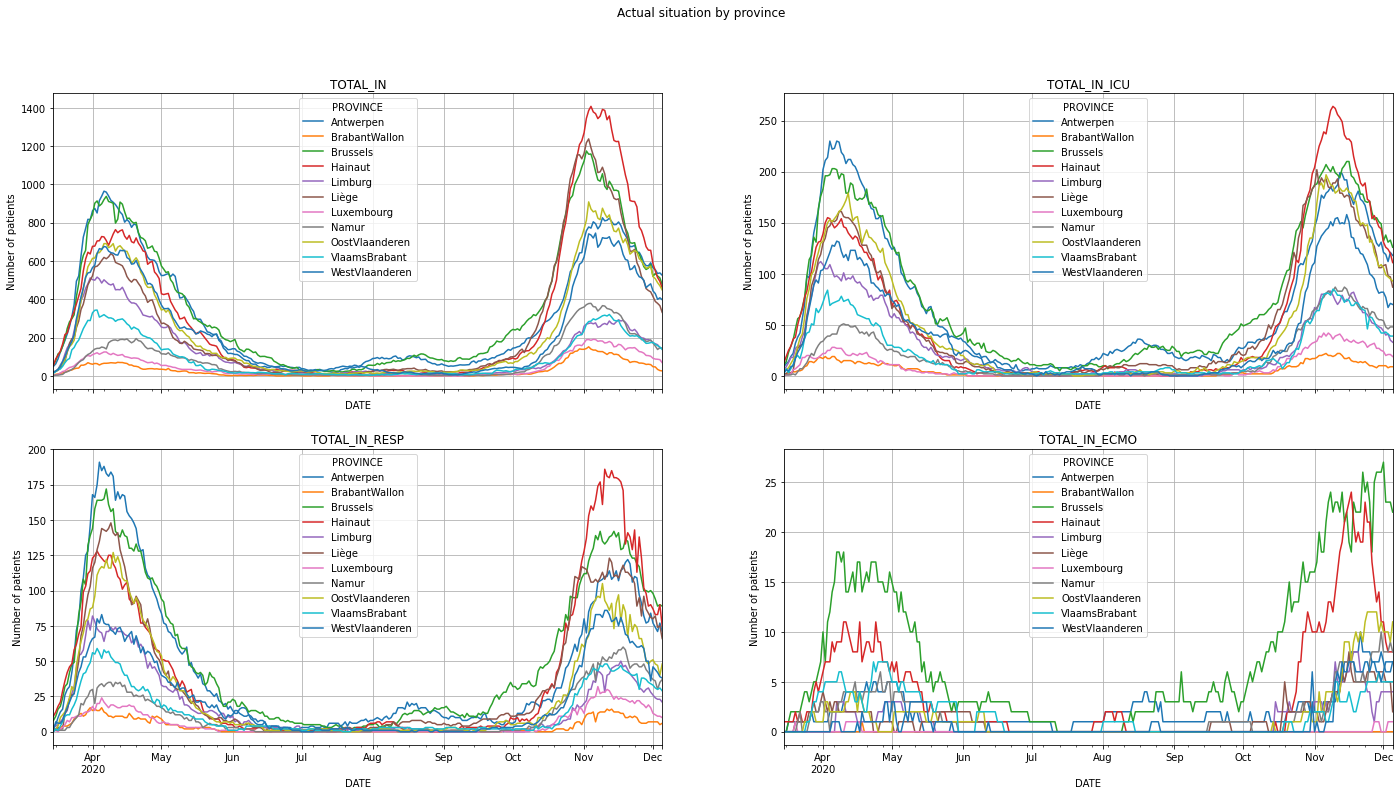

In [5]:
@plot_all()
def Actual_situation_by_province(ax, col):
    df[col].plot(ax=ax)
    ax.grid()
    ax.set_ylabel('Number of patients')

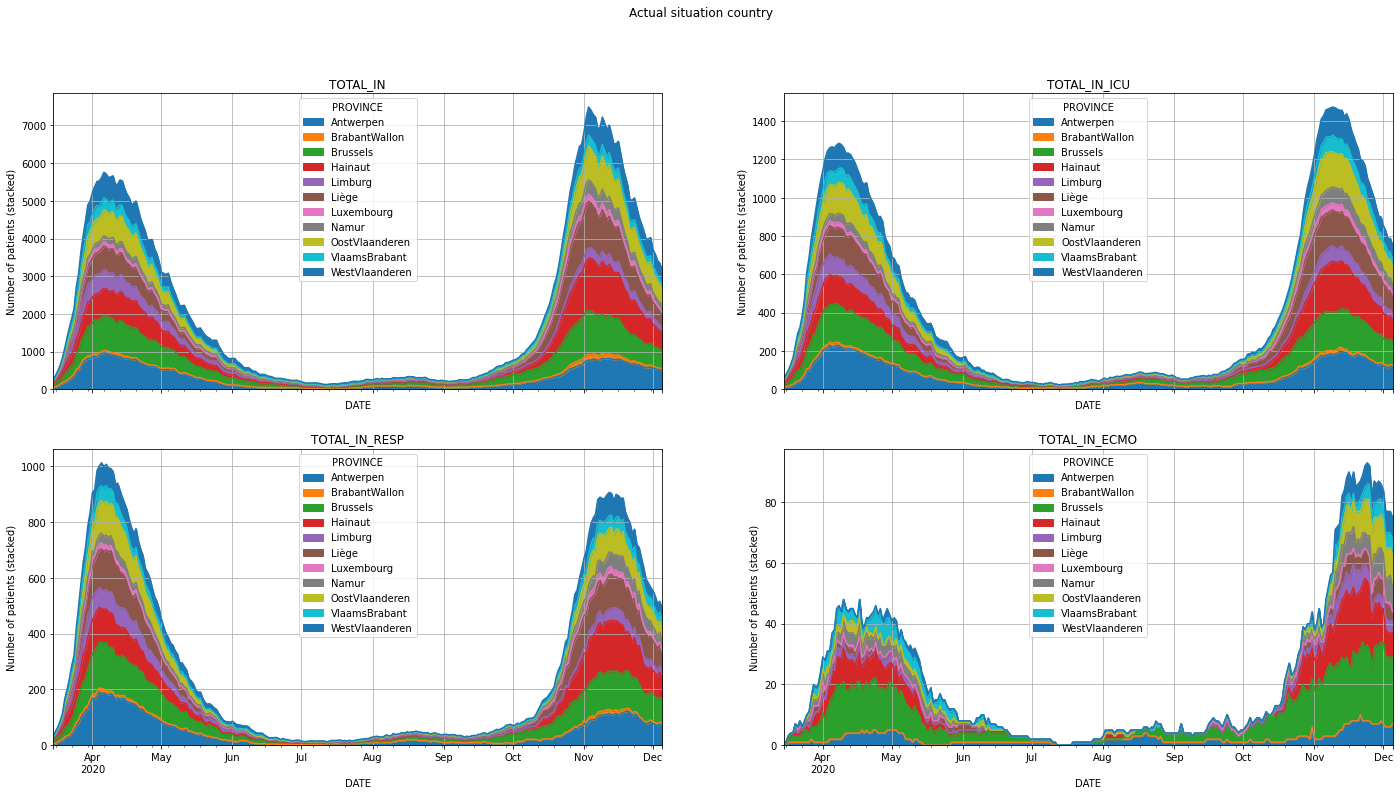

In [6]:
@plot_all()
def Actual_situation_country(ax, col):
    df[col].plot(kind='area', stacked=True, ax=ax)
    ax.grid()
    ax.set_ylabel('Number of patients (stacked)')

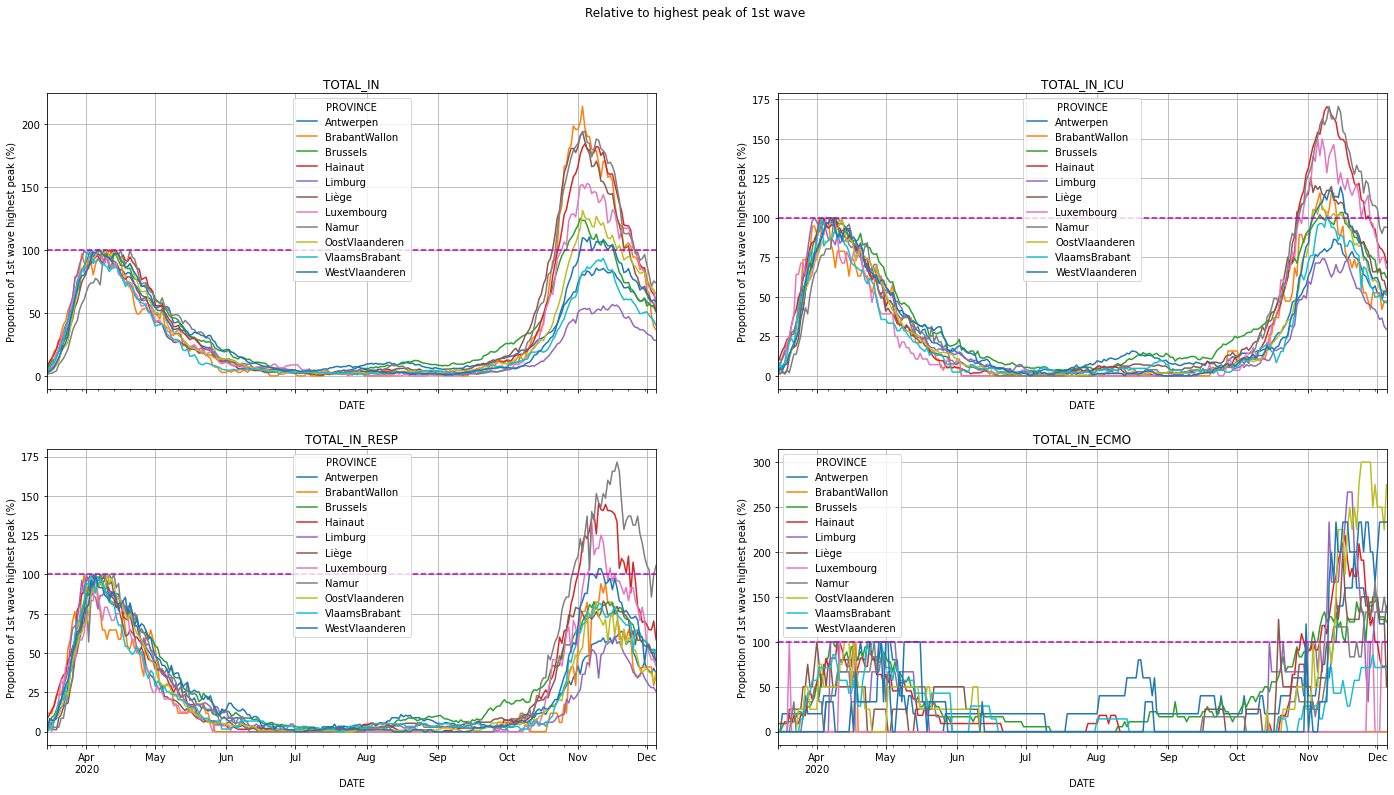

In [7]:
@plot_all()
def Relative_to_highest_peak_of_1st_wave(ax, col):
    (100 * df / PEAK_FIRST_WAVE)[col].plot(ax=ax)
    ax.grid()
    ax.axhline(100, c='m', ls='--')
    ax.set_ylabel('Proportion of 1st wave highest peak (%)')

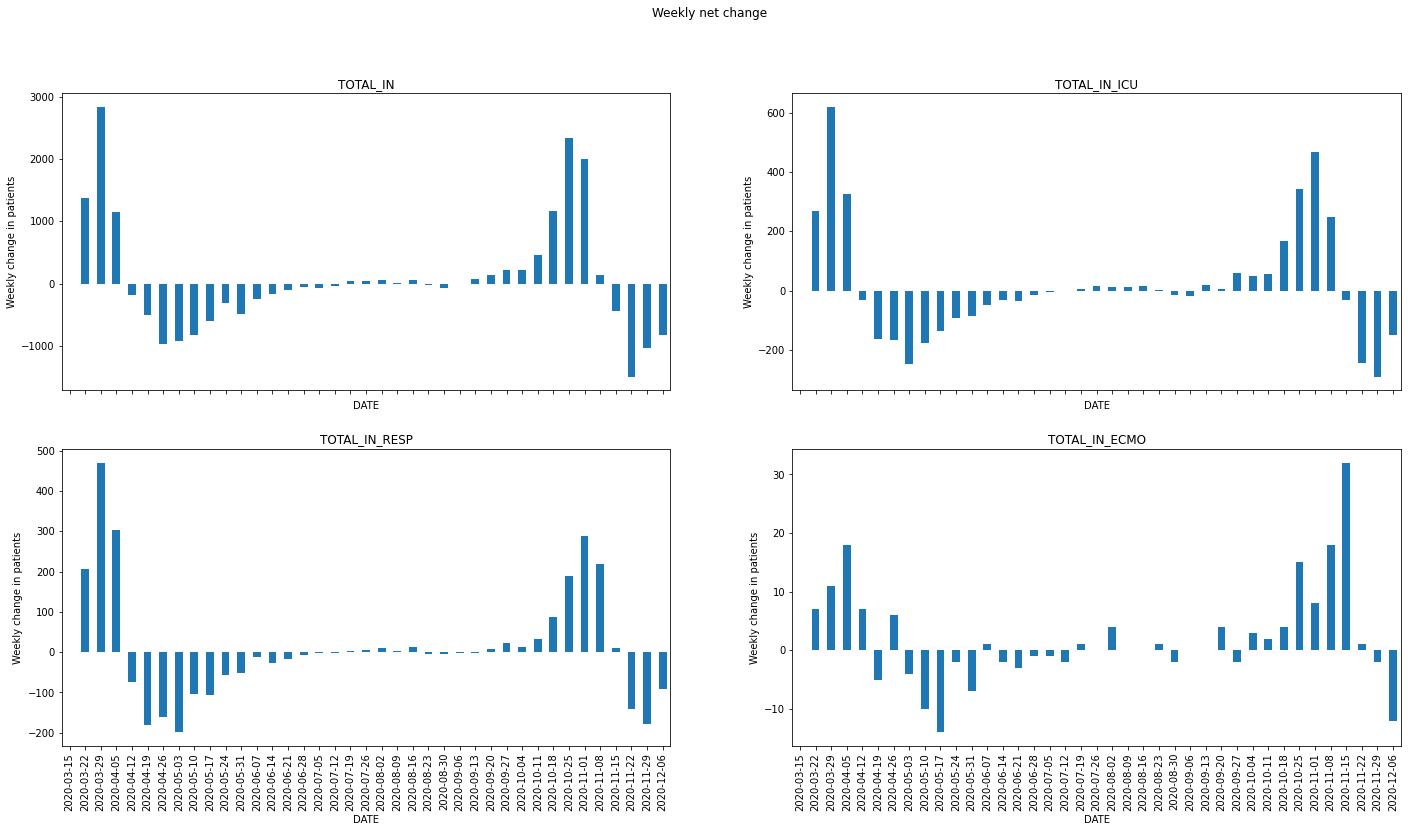

In [8]:
@plot_all()
def Weekly_net_change(ax, col):
    weekly_change = df[col].sum(axis=1).diff().resample('1w').sum()
    weekly_change.reindex([x.date() for x in weekly_change.index]).plot(kind='bar', ax=ax)
    ax.set_ylabel('Weekly change in patients')